In [1]:
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

Make Data

In [2]:
%load_ext autoreload
%autoreload 2

import malt
import torch
import seaborn as sns
from malt.molecule import Molecule

Using backend: pytorch


In [19]:
from malt.data.collections import esol

data = esol()
data.shuffle(seed=1)
data_tr, data_te = data.split([8, 2])

Processing dgl graphs from scratch...
Processing molecule 1000/1128


In [21]:
train_x, train_y = data_tr.batch()
test_x, test_y = data_te.batch()
train_y, test_y = train_y.ravel(), test_y.ravel()

In [ ]:
# initialize
feature_extractor = malt.models.representation.DGLRepresentation(
        out_features=32, hidden_features=32,
).cuda()

# feature_extractor = LargeFeatureExtractor()

In [293]:
class GPRTest(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRTest, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=32)
        )

    def forward(self, projected_x):
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [294]:
class ModularModel(gpytorch.models.GP):
    def __init__(self, representation, regressor, likelihood, train_y):
        """
            Args:
                - gp (gpytorch.models.ExactGP): A GP that expects to operate on features extracted by a GCN.
                - gcn (torch.nn.Module): Some PyTorch module that extracts graph features.
                - train_x (any input to gcn): The training data as expected by the GCN
                - train_y (torch.Tensor): Training labels
        """
        super(ModularModel, self).__init__()
        self.representation = representation
        self.regressor = regressor
        self.likelihood = likelihood

        self.train_targets = train_y
    
    def forward(self, train_x):
        train_h = self.representation(train_x)
        if self.training:
            self.regressor.set_train_data(train_h, self.train_targets, strict=False)
        return self.regressor(train_h)

In [295]:
def make_model_and_likelihood(architecture='modular'):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    if architecture == 'modular':
        gprt = GPRTest(torch.ones(30), train_y, likelihood)
        # the requirement to give train_y is unnecessary with a smarter training loop
        model = ModularModel(feature_extractor, gprt, likelihood, train_y)

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    return model, likelihood

In [296]:
def train_model(model, likelihood, train_x, train_y, smoke_test=False):
    def _train(): 
        # iterator = tqdm.notebook.tqdm(range(training_iterations))
        loss_history = []
        for i in range(training_iterations):
            # Zero backprop gradients
            optimizer.zero_grad()
            # Get output from model
            output = model(train_x)
            # Calc loss and backprop derivatives
            loss = -mll(output, train_y).mean()
            loss.backward()
            optimizer.step()
            loss_history.append(loss.item())
        return model, loss_history

    smoke_test = False
    training_iterations = 0 if smoke_test else 100

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
    ], lr=1e-3)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    # train
    model = _train()
    
    return model

def test(model, test_x, test_y):
    from scipy.stats import pearsonr
    model.eval()
    with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
        preds = model(test_x)
    rmse = torch.sqrt(torch.mean(torch.pow(preds.mean - test_y, 2))).item()
    mae = torch.mean(torch.abs(preds.mean - test_y)).item()
    corr, _ = pearsonr(preds.mean.tolist(), test_y.tolist())
    r2 = malt.metrics.base_metrics.r2(preds.loc, test_y).item()
    return rmse, mae, corr, r2

results = []
for architecture in ['modular']:
    for i in tqdm.tqdm(range(10)):
        model, likelihood = make_model_and_likelihood(architecture=architecture)
        model, loss_history = train_model(model, likelihood, train_x, train_y, smoke_test=False)
        rmse_train, mae_train, corr_train, r2_train = test(model, train_x, train_y)
        rmse_test, mae_test, corr_test, r2_test = test(model, test_x, test_y)
        results.append(
            {
                'architecture': architecture,
                'corr_train': corr_train,
                'r2_train': r2_train,
                'mae_train': mae_train,
                'rmse_train': rmse_train,
                'corr_test': corr_test,
                'r2_test': r2_test,
                'mae_test': mae_test,
                'rmse_test': rmse_test,
                'loss': loss_history,
            }
        )

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:07<00:00,  6.72s/it]


In [297]:
import pandas as pd
pd.DataFrame(results).groupby('architecture').agg(('mean', 'std'))

C:\Users\micha\AppData\Local\Temp\ipykernel_18368\414440159.py:2: FutureWarning: ['loss'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  pd.DataFrame(results).groupby('architecture').agg(('mean', 'std'))


corr_train            r2_train           mae_train            \
                   mean       std      mean       std      mean       std   
architecture                                                                
modular        0.956574  0.009026  0.882716  0.026963  0.554135  0.074223   

             rmse_train           corr_test             r2_test            \
                   mean       std      mean       std      mean       std   
architecture                                                                
modular        0.708689  0.081551   0.95772  0.006064  0.884872  0.029834   

              mae_test           rmse_test            
                  mean       std      mean       std  
architecture                                          
modular       0.557005  0.070064  0.724744  0.093212

In [298]:
pd.DataFrame(results)

,architecture,corr_train,r2_train,mae_train,rmse_train,corr_test,r2_test,mae_test,rmse_test,loss
0,modular,0.935007,0.860627,0.596749,0.777138,0.942129,0.876540,0.616307,0.756078,"[2.61714506149292, 2.5809714794158936, 2.54049..."
1,modular,0.947833,0.897671,0.509488,0.665898,0.956752,0.912854,0.515687,0.635224,"[1.2449951171875, 1.6401915550231934, 1.301835..."
2,modular,0.953526,0.877353,0.568976,0.729017,0.959102,0.888124,0.547770,0.719734,"[1.164920687675476, 1.4104291200637817, 1.2109..."
3,modular,0.958918,0.914957,0.463990,0.607056,0.962084,0.918880,0.472649,0.612868,"[1.1348557472229004, 1.4881178140640259, 1.247..."
4,modular,0.960260,0.916528,0.456833,0.601422,0.962508,0.919007,0.466233,0.612389,"[1.1051318645477295, 1.2734743356704712, 1.180..."
5,modular,0.960113,0.867296,0.603451,0.758316,0.959204,0.867033,0.589618,0.784648,"[1.0952177047729492, 1.709147572517395, 1.2670..."
6,modular,0.963459,0.907426,0.490605,0.633363,0.961860,0.902872,0.504773,0.670618,"[1.0859709978103638, 1.3684605360031128, 1.179..."
7,modular,0.963861,0.884371,0.563943,0.707850,0.961512,0.878594,0.567310,0.749762,"[1.0767742395401, 1.595017910003662, 1.2433860..."
8,modular,0.959958,0.869016,0.591861,0.753386,0.954686,0.858805,0.599112,0.808561,"[1.0714296102523804, 1.3495622873306274, 1.155..."
9,modular,0.962806,0.831913,0.695451,0.853447,0.957359,0.826011,0.690589,0.897562,"[1.0683802366256714, 1.4571950435638428, 1.202..."


In [276]:
model.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(train_x)
    
from malt.metrics.base_metrics import r2
r2(preds.loc, train_y)

tensor(0.8515, device='cuda:0')

Text(0.5, 1.0, 'gpytorch: training')

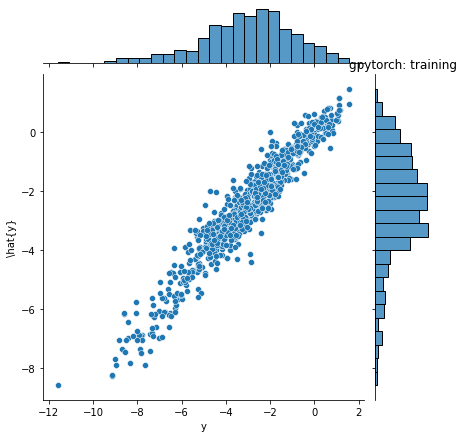

In [271]:
g = sns.jointplot(x = train_y.tolist(), y = (preds.loc).tolist())
g.set_axis_labels('y', '\hat{y}')
plt.title('gpytorch: training')